<h1>Benvenuti!</h1>

Cerchiamo di mostrarvi qui i primi progressi del nostro (duro) lavoro. L'idea di questo notebook è di permettere a esperti e non esperti/non programmatori di poter giocare con il codice senza necessariamente doverci capire qualcosa.

Il funzionamento dovrebbe essere abbastanza semplice. O si fa "run all" o uno alla volta si eseguono tutti i blocchi di testo. Aggiungiamo commenti o testo per spiegare

Questa sezione sono gli _import_. Praticamente importiamo alcune librerie che ci servono per fare magie. Nulla di appariscente, ma fondamentale.

In [16]:
# Import all packages

# una libreria per leggere gli shapefile --> info qui: http://geopandas.org/index.html
import geopandas as gpd
# per i grafici
import matplotlib.pyplot as plt
# per il debug
import pdb
# per le cartelle
import os
#test per il push
import networkx as nt
from networkx.exception import NetworkXNoPath
import numpy as np
#libreria per leggere gli attributi degli edge
import json
#libreria per convertire da Json a shapely
from shapely.geometry import mapping, shape
#utility per coordinates
from library_coords import civico2coord

Ora leggiamo i file. I file .shp sono gli shapefile che contengono la forma di venezia, le calli e le strade con i nomi e le posizioni geografiche. Ci serviranno per dire all'algoritmo dove vogliamo andare.

In [11]:
#la cartella dove ci troviamo
folder = os.getcwd()
# creiamo un file geografico con la mappa di venezia
geo_venezia = gpd.read_file(folder + "/pontiDivisi_completo/pontiDivisi_solo_venezia_l.shp")
# questo contiene i nomi delle strade per cercare dove siamo e dove vogliamo andare
geo_nomi_venezia = gpd.read_file(folder + "/pontiDivisi_completo/civico_new.shp")
# questo è un grafo che ci serve per fare le magie con i ponti
G = nt.read_shp(folder + "/pontiDivisi_completo/pontiDivisi_solo_venezia_l.shp")
# ci serve che il grafo sia undirected, malvagità, nulla di importante
G_un = G.to_undirected()
G_list = list(G_un.nodes)

Ora possiamo plottare per mostrare cosa intendiamo con la mappa di venezia!

Text(0.5, 1.0, 'VENEZIA')

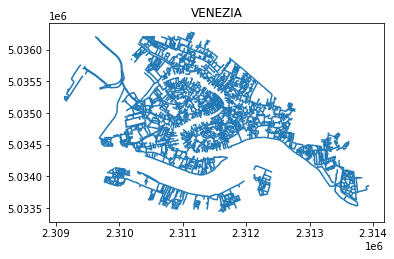

In [8]:
#plottiamo venezia
geo_venezia.plot()
plt.title('VENEZIA')

Ora ci servono delle funzioni per calcolare la strada e le strade alternative per incontrare meno ponti

In [12]:
# funzione per i ponti
def weight_bridge(x,y,dic):
    return dic["length"] + dic["ponte"]*100

In [27]:
# funzione che disegna la strada piu corta
def plot_shortest_path(path_nodes,map_shp):
    # path_nodes lista di nodi attraversati
    # map_shp shapefile generale della mappa su cui si cerca il percorso

    # Converte la lista di nodi in file json
    shapes = []
    for i in range(len(path_nodes)-1):
        shapes.append(shape(json.loads(G_un[path_nodes[i] ][path_nodes[i+1] ]['Json'])))
    x_tot = []
    for sha in shapes:
    #   print(sha.coords.xy)
        x = []
        for i in range(len(sha.coords.xy[0])):
            x.append((sha.coords.xy[0][i],sha.coords.xy[1][i]))
        # to be corrected with x_start
        if not x_tot:
            x_tot+=x
        elif x[0] == x_tot[-1]:
    #        print(x[0], "uguali",x_tot[-1])
            x_tot+=x
        else:
    #        print(x[0],"diversi", x_tot[-1])
            x_tot+=x[::-1]

    x_tot = np.asarray(x_tot)
    plt.figure()
    map_shp.plot()
    plt.plot(x_tot[:,0], x_tot[:,1], c="r")
    plt.title("Venezia e il percorso ottimo")
    map_shp.plot()
    plt.plot(x_tot[:,0], x_tot[:,1], c="r")
    plt.title("Zoom sul percorso ottimo")
    plt.xlim(min(coord[0], coord2[0]) - 100, max(coord[0], coord2[0]) + 100)
    plt.ylim(min(coord[1], coord2[1]) - 100, max(coord[1], coord2[1]) + 100)
    return

Ok, ora possiamo finalmente provare. Lancia la prossima parte e ti verrà chiesto di inserire un indirizzo e di scegliere tra i 3 migliori risultati. Quella sarà la partenza. 

In [18]:
starting_address = input('Da dove parti?\n')
coord = civico2coord(G_list, starting_address, geo_nomi_venezia)

Da dove parti?
Dorsoduro 3479
Trovato: 0:DORSODURO, 3479
Quale intendi? Scrivi il numero
0


In [20]:
ending_address = input('Dove ti va?\n')
coord2 = civico2coord(G_list, ending_address, geo_nomi_venezia)

Dove ti va?
Santa Croce 343
Trovato: 0:SANTA CROCE, 343
Quale intendi? Scrivi il numero
0


Ora, andiamo da Dorsoduro 3479 a Santa Croce 343. Se cerchiamo la strada più corta, la nostra risposta sarà:

<Figure size 432x288 with 0 Axes>

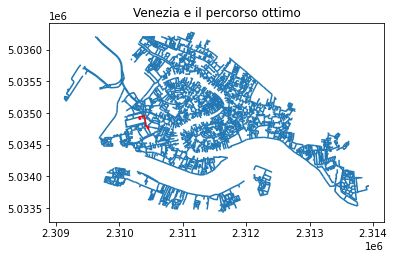

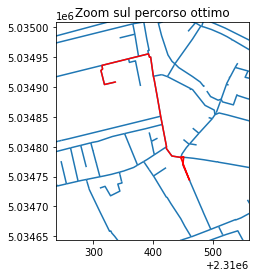

In [28]:
try:
    # per i malvagi, usiamo la lunghezza degli archi (le calli) per calcolare il percorso piu breve
    path = nt.algorithms.shortest_paths.weighted.dijkstra_path(G_un,coord,coord2, weight="length")
    # lista dei nodi attraversati
    path_nodes = [n for n in path]
    plot_shortest_path(path_nodes, geo_venezia)
except NetworkXNoPath:
    print("Non esiste un percorso tra i due nodi")
    ponti.plot()

Interessante! Ma se siamo pigri e non vogliamo fare i ponti? O se abbiamo problemi di deambulazione? Possiamo chiedere al nostro caro algoritmo, di incontrare per strada il minor numero di ponti possibili!

<Figure size 432x288 with 0 Axes>

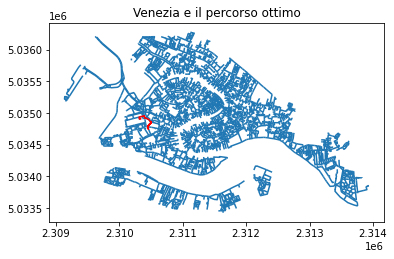

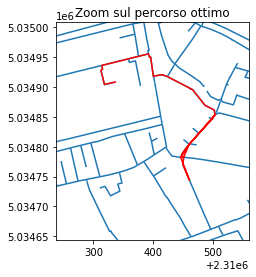

In [29]:
try:
    # per i malvagi, qui usiamo una funzione che pesa un ponte come 100 metri. Quindi l'algoritmo eviterà i ponti
    length_path, path_nobridges = nt.algorithms.shortest_paths.weighted.single_source_dijkstra(G_un, coord,coord2, weight = weight_bridge)
    # lista dei nodi attraversati
    path_nodes_nobridges = [n for n in path_nobridges]
    plot_shortest_path(path_nodes_nobridges, geo_venezia)
except NetworkXNoPath:
    print("Non esiste un percorso tra i due nodi")
    ponti.plot()

Come vedete qui sopra, la strada con meno ponti è diversa! Se cercate di immaginare dove siamo (zona tre ponti) ha senso ed effettivamente è quello che volevamo!